# Simple classification problem

The following is an example notebook with classification problem. The data science problem here is kept intentionally small and trivial to understand. This is because we don't want you to focus on the data science problem, but to think about all kinds of ML Engineering challenges that might happen in production scenarios.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import classification_report


/Users/s.radhakrishnan/.pyenv/versions/3.9-dev-debug/lib/python3.9/site-packages/sklearn/utils/multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/Users/s.radhakrishnan/.pyenv/versions/3.9-dev-debug/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/Users/s.radhakrishnan/.pyenv/versions/3.9-dev-debug/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe1` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1


Read initial data

In [73]:
df = pd.read_csv(
    "data/historical_sensor_data.csv",
    sep=','
)
df.head()
df.describe()
df

,sensor_1,sensor_2,label
0,-0.940230,1.411390,0.0
1,0.266017,0.474068,0.0
2,1.912074,0.456729,1.0
3,0.414918,-0.504954,0.0
4,1.925371,0.129880,1.0
...,...,...,...
1495,-0.672065,0.218704,1.0
1496,-0.368025,-0.571421,1.0
1497,1.061114,-1.350991,1.0
1498,-1.145491,1.276470,0.0


## Data exploration, Preprocess and obtain train and test data:

Given code is wrapped here into a seperate method and returns the train-test split dataframes that could be used bx other methods. By this way, its always a good practice to have clean codes wrapped in python functions which can be easily reproducible and production ready. 

In [70]:
### Testing with predict function - # to predict class values

x_values = df[['sensor_1', 'sensor_2']]
y_values = df['label']
    
X_train_values, X_test_values, y_train_values, y_test_values = train_test_split(
        x_values, y_values, test_size=0.3, random_state=99
    )
print(X_train_values.shape)
print(X_test_values.shape)
print(y_train_values.shape)
print(y_test_values.shape)

model = GaussianProcessClassifier(1.0 * RBF(1.0))
model.fit(X_train_values, y_train_values)
y_pred_values = model.predict(X_test_values)
print(classification_report(y_test_values, y_pred_values))

(1050, 2)
(450, 2)
(1050,)
(450,)
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       224
         1.0       1.00      0.96      0.98       226

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Gaussian process classifier: f1=0.977 auc=0.999


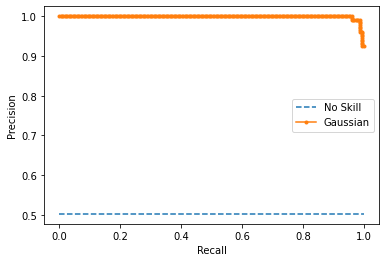

In [66]:
#PR curves

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

gs_probs = model.predict_proba(X_test_values)
# keep probabilities for the positive outcome only
gs_probs = gs_probs[:, 1]
gs_precision, gs_recall, _ = precision_recall_curve(y_test, gs_probs)
gs_f1, gs_auc = f1_score(y_test, y_pred_values), auc(gs_recall, gs_precision)
# summarize scores
print('Gaussian process classifier: f1=%.3f auc=%.3f' % (gs_f1, gs_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(gs_recall, gs_precision, marker='.', label='Gaussian')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
Gaussian: ROC AUC=0.999


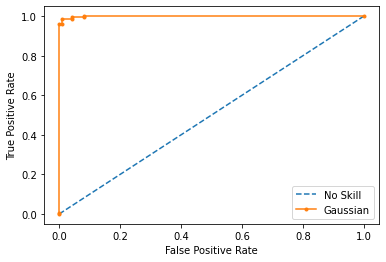

In [69]:
#roc curve

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
gs_auc = roc_auc_score(y_test, gs_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Gaussian: ROC AUC=%.3f' % (gs_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
gs_fpr, gs_tpr, _ = roc_curve(y_test, gs_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(gs_fpr, gs_tpr, marker='.', label='Gaussian')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [47]:
def data_preprocess(df):
    """
        Data preprocessing is done in this function including train-test split. 
        Parameters: 
            df: Input dataframe
        Returns:
            X_train: Training data,
            X_test: Testing data,
            y_train: Training label,
            y_test: Testing label
            xx,yy: co-ordinates for plotting
    """
    X = df[['sensor_1', 'sensor_2']].values
    y = df[['label',]].values
    
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=99
    )
    h = 0.02 # meshgrid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    return X_train,X_test,y_train,y_test,xx,yy

In [48]:
X_train,X_test,y_train,y_test,xx,yy = data_preprocess(df)

Plot the data

<module 'matplotlib.pyplot' from '/Users/s.radhakrishnan/.pyenv/versions/3.9-dev-debug/lib/python3.9/site-packages/matplotlib/pyplot.py'>

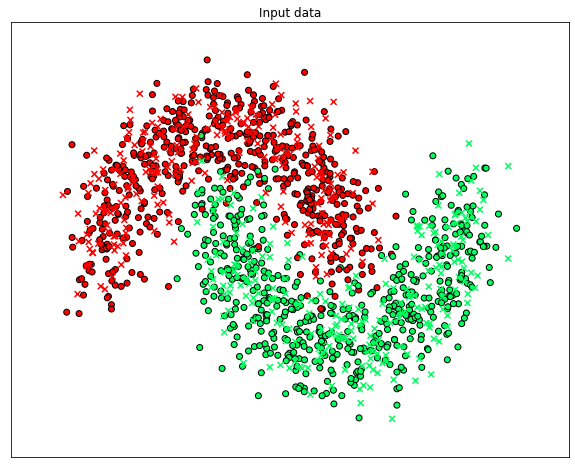

In [15]:
def data_visualize(X_train,X_test,xx,yy):
    """
    This function is used to visualize the raw input data by plotting data points in scatter plots. 
    Parameters:
        X_train: Training data,
        X_test: Testing data,
        xx,yy: co-ordinates for plotting
    Returns:
        plt: scatter plot of training and testing data except the labels.   
    """
    # just plot the dataset first
    plt.figure(figsize=(10,8))
    cm = plt.cm.PiYG
    cm_bright = ListedColormap(["#FF0000", "#00ff5e"])
    plt.title("Input data")

    # Plot the training points
    plt.scatter(
        X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
    )
    # Plot the testing points
    plt.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, marker='x',  cmap=cm_bright, alpha=1 
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    return plt,cm,cm_bright

plt,cm,cm_bright = data_visualize(X_train,X_test,xx,yy)
plt

Create and train model, Run Inference, Plot the results of inference

(1050, 2)
(450, 2)
(1050, 1)
(283, 268)


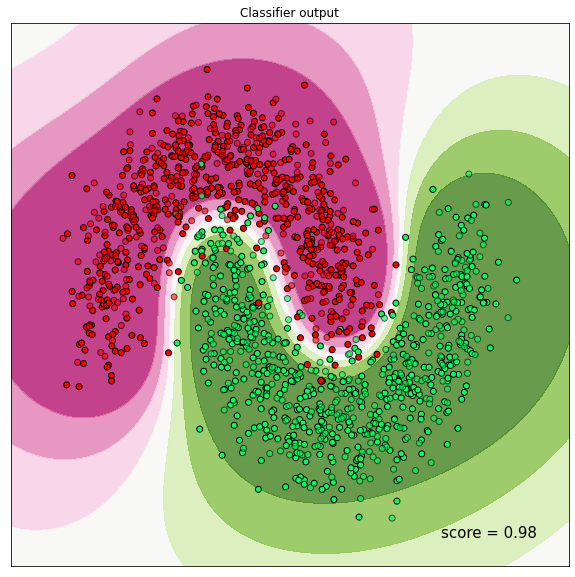

In [53]:
def train_model(X_train,X_test,y_train,y_test,xx,yy,cm,cm_bright):
    """
    This functions trains a classification model and plots the training and testing data along with the 
    labels to visualize the classifier output. 
    Parameters:
        X_train: Training data,
        X_test: Testing data,
        y_train: Training label,
        y_test: Testing label
        xx,yy: co-ordinates for plotting
    Returns:
        clf: classifying model
    """
    clf = GaussianProcessClassifier(1.0 * RBF(1.0))
    clf.fit(X_train, y_train.ravel())
    score = clf.score(X_test, y_test)
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] # predicting probabilities and taking only positive outcomes
    Z = Z.reshape(xx.shape)
    print(xx.shape)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

    # Plot the training points
    ax.scatter(
        X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
    )
    # Plot the testing points
    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=y_test,
        cmap=cm_bright,
        edgecolors="k",
        alpha=0.6,
    )

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

    ax.set_title("Classifier output")
    ax.text(
        xx.max() - 0.3,
        yy.min() + 0.3,
        (f"score = {score:.2f}").lstrip("0"),
        size=15,
        horizontalalignment="right",
    )
    return clf,xx,yy,Z
clf,xx,yy,Z = train_model(X_train,X_test,y_train,y_test,xx,yy,cm,cm_bright)

# Inference

Classification of the latest sensor data

## read the latest data

In [77]:

inference_df = pd.read_csv(
    "data/latest_sensor_data.csv",
    sep=','
)
inference_df.head()
inference_df.describe()

,sensor_1,sensor_2
count,42.000000,42.000000
mean,1.407543,1.148582
std,0.892263,0.525011
min,-0.397912,0.160248
25%,0.766698,0.690832
50%,1.447133,1.255488
75%,2.112319,1.590154
max,3.101939,1.997163


## predict labels and plot the inference

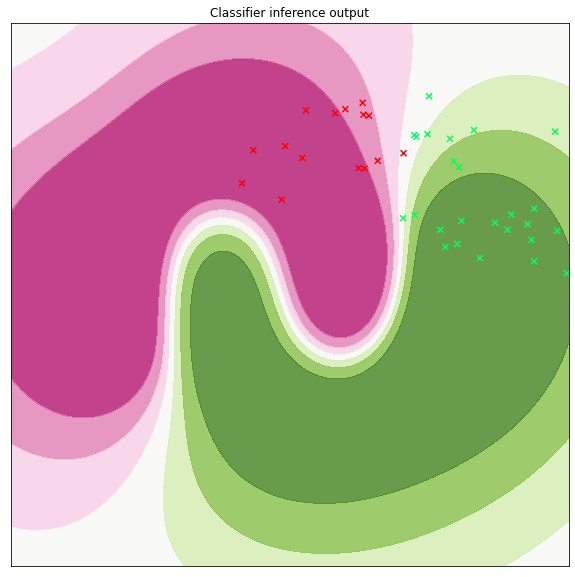

In [32]:

def predict(inference_df,cm,cm_bright,xx, yy, Z):
    """
    This functions predicts the label using the guassian classifier model and plots the output of the inference data
    Parameters:
        inference_df: latest inference data
        cm,cm_bright: colour map in plots
        xx,yy: co-ordinates for plotting
        z: reshaping the predicted probability
    Returns:
        ypred : predictions of the label
    """
    X_inference = inference_df.values
    
    # predict labels
    y_pred = clf.predict_proba(X_inference)[:, 1]
    inference_df = inference_df.assign(y_pred = np.round(y_pred, 0))
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

    # Plot the inference points
    ax.scatter(
        X_inference[:, 0], X_inference[:, 1], marker="x", c=y_pred, cmap=cm_bright
    )

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title("Classifier inference output")
    return y_pred
    
pred_results= predict(inference_df,cm,cm_bright,xx, yy, Z)
    